# <center> Projet :  Moteur de classification </center>



<img src="https://www.affacturage.fr/img/produits/place-de-marche-marketplace.jpg" width=492>


### <center>Thème : Marketplace </center>
### <center>https://openclassrooms.com/fr/paths/164/projects/631/assignment<center>

In [1]:
#https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb

# Objectif du notebook

L'objet de ce projet est de proposer une étude de faisabilité d'un moteur de classification d'articles  à partir d'une image ou de la description de l'image. 

Tous les modèles contiennent un prétraitement, une réduction de dimension et une étape de clustering. L'ARI entre les catégories rééelles et les clusters modélisés est notre métrique d'évaluation. Un ARI entre 0.4 et 0.6 en non supervisé peut être satisfaisant.


Notre notebook contient : 
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 



In [2]:
#Data management/data viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


#Statistiques/ML
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score # score recall
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import manifold, decomposition
from sklearn.mixture import GaussianMixture
from sklearn import cluster, metrics
from sklearn.metrics import (
    adjusted_rand_score as ari
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.manifold._t_sne import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import fcluster, linkage
import scipy

#Image
from PIL import Image
from IPython.display import  display
from PIL import ImageFilter
import cv2 
from matplotlib.image import imread

#Texte
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow_hub as hub

#Keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

#Transformers
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer


#Autres
import time, cv2
import os
pd.set_option('display.max_columns', None) #Afficher toute les colonnes
import gensim
from pickle import dump



# example of using the vgg16 model as a feature extraction model
from keras.preprocessing.image import load_img






# Data Management

Dans cette partie nous chargeons et manipulons  les données.

Chargement du jeu de données.

In [3]:
try :
    df=pd.read_csv("E_commerce.csv")
    os.chdir(os.getcwd()+"/Images")
except :
    df.head()

In [4]:
print(df.shape)

(1050, 15)


On a 1050 biens de consommations regrouppés en 15 caractéristiques.

In [5]:
df.product_category_tree.value_counts()

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1
Name: product_categor

Les catégories sont trop diversifiées et notre jeu de données est petit. Nous allons alléger les catégories.

In [6]:
categorie =df.product_category_tree[0].split(" >>")[0]
categorie =categorie.replace("[", "")
categorie =categorie.replace("''", "")
categorie=categorie.replace("\"", "")
categorie

'Home Furnishing'

In [7]:
def target(categorie):
    """Creation catégorie des articles"""
    categorie =categorie.split(" >>")[0]
    categorie =categorie.replace("[", "")
    categorie =categorie.replace("''", "")
    categorie=categorie.replace("\"", "")
    return(categorie)
    
target(df.product_category_tree[0])    
target(df.product_category_tree[30])    

'Watches'

In [8]:
df["categorie_article"]=0

df["categorie_article"]=df["product_category_tree"].apply(lambda x: target(x))
df["categorie_article"].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: categorie_article, dtype: int64

On a 7 catégories d'articles avec 150 échantillons chacun.

Les données images sont récupérables à partir de la colonne image.

In [9]:
df["image"][1]

'7b72c92c2f6c40268628ec5f14c6d590.jpg'

Les données textes sont dans la colonne description. Ils correspondent à la description du produit.

In [10]:
df["product_url"][1]

'http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH'

In [11]:
df["description"][1]

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

# Partie Image

Dans cette partie, nous étudierons la faisabilité d'un moteur de classiffication en utilisant uniquement les images des articles de notre échantillon.

### Pré-processing

Nous allons rendre propres les images de notre dataset.

In [12]:
df_image=df[["categorie_article","image"]]
df_image["image_propre"]=df.index
df_image["image_propre"]=df_image["image_propre"].apply(lambda x: str(x)+".jpg")
df_image.head()

/var/folders/89/26039wtj391246qzh04sn04c0000gn/T/ipykernel_38369/3983569253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image["image_propre"]=df.index
/var/folders/89/26039wtj391246qzh04sn04c0000gn/T/ipykernel_38369/3983569253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image["image_propre"]=df_image["image_propre"].apply(lambda x: str(x)+".jpg")


categorie_article                                 image image_propre
0   Home Furnishing  55b85ea15a1536d46b7190ad6fff8ce7.jpg        0.jpg
1         Baby Care  7b72c92c2f6c40268628ec5f14c6d590.jpg        1.jpg
2         Baby Care  64d5d4a258243731dc7bbb1eef49ad74.jpg        2.jpg
3   Home Furnishing  d4684dcdc759dd9cdf41504698d737d8.jpg        3.jpg
4   Home Furnishing  6325b6870c54cd47be6ebfbffa620ec7.jpg        4.jpg

In [13]:
exemple_Watch=[index for index, value in enumerate(list(df_image["categorie_article"]=="Watches")) if value == 1][:3]
exemple_Baby=[index for index, value in enumerate(list(df_image["categorie_article"]=="Baby Care")) if value == 1][:3]
exemple_Computer=[index for index, value in enumerate(list(df_image["categorie_article"]=="Computers")) if value == 1][:3]

Baby Care


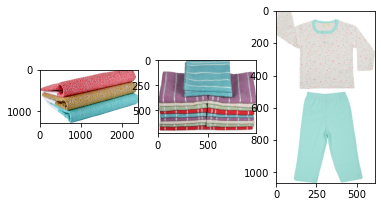

Computer


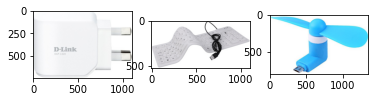

Watches


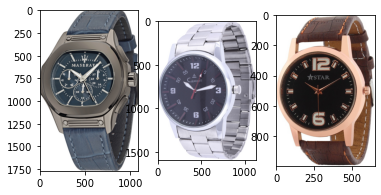

In [14]:
print("Baby Care")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Baby[i],"image"]))
plt.show()
print("Computer")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Computer[i],"image"]))
plt.show()
print("Watches")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Watch[i],"image"]))
plt.show()


Deux étapes de nettoyags ont été appliqués :
- passage au gris
- Ajustement du contraste par l

In [15]:
#image=cv2.GaussianBlur(image,(51,51),0) # éliminaation du bruit
#image=cv2.medianBlur(image, 5 )
from PIL import ImageFilter

# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat


for i in range(len(df_image.image)):
    image = cv2.imread(df_image.image[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    #image=cv2.GaussianBlur(image,(51,51),0)
    #image=cv2.resize(image,(224,224))
    #image=cv2.medianBlur(image, 5 )
    nom=str(i)
    cv2.imwrite(str(nom)+".jpg", image) 
    print("ok")

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

Baby Care


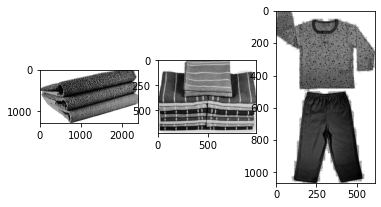

Computer


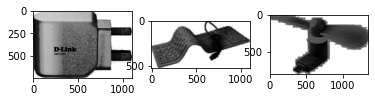

Watches


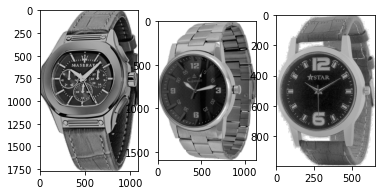

In [16]:
print("Baby Care")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Baby[i],"image_propre"]),cmap='gray')
plt.show()
print("Computer")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Computer[i],"image_propre"]),cmap='gray')
plt.show()
print("Watches")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Watch[i],"image_propre"]),cmap='gray')
plt.show()

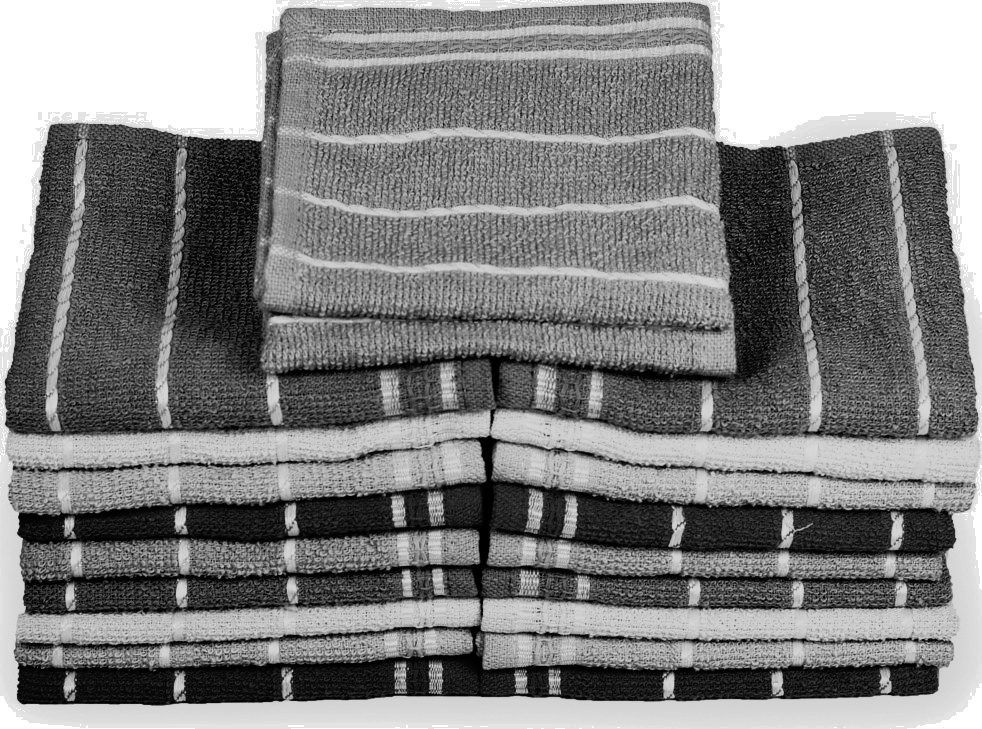

Taille de la matrice de pixels : (729, 982)


In [17]:
#exemple d'image
img = Image.open("2.jpg") 
display(img)
mat = np.array(img)
print("Taille de la matrice de pixels : {}".format(mat.shape))

### Approche SIFT

La scale-invariant feature transform (SIFT), que l'on peut traduire par « transformation de caractéristiques visuelles invariante à l'échelle », est un algorithme utilisé dans le domaine de la vision par ordinateur pour détecter et identifier les éléments similaires entre différentes images numériques (éléments de paysages, objets, personnes, etc.). Il a été développé en 1999 par le chercheur David Lowe.

L'approche ORB est gratuite pour la production par rapport à SIFT et SURF

##### Création des descripteurs et des clusteurs

Exemple sur une image :

[ WARN:0@49.570] global /Users/runner/work/opencv-python/opencv-python/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


On a 500 features.


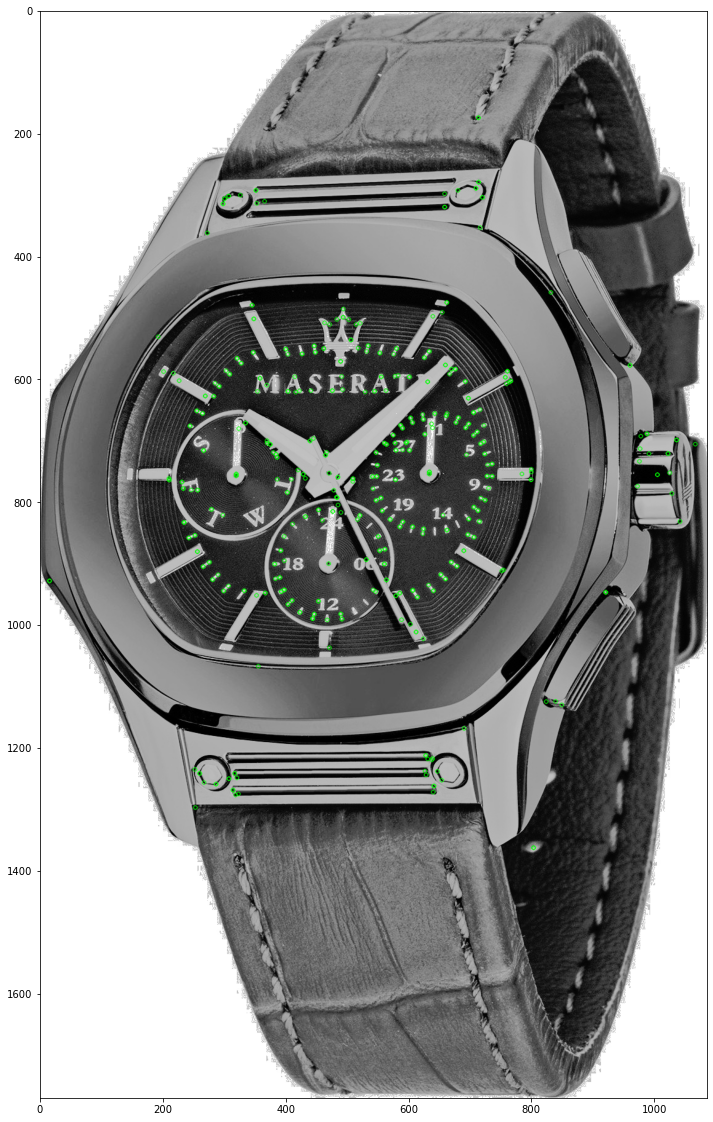

In [18]:
#SIFT_create prend en argument le nombre de features que l'on souhaite avoir
test=imread("5.jpg")
sift = cv2.xfeatures2d.SIFT_create(500) # Ce choix est-il arbitraire ?
kp=sift.detect(test,None)
print("On a",len(kp),"features.")
gray=cv2.drawKeypoints(test,kp, 0, (0, 255, 0))
plt.figure(figsize = (50,20))
plt.imshow(gray)

In [19]:
df_image=df_image[["categorie_article","image_propre"]]
df_image
#df_image.groupby("categorie_article").count()

categorie_article image_propre
0      Home Furnishing        0.jpg
1            Baby Care        1.jpg
2            Baby Care        2.jpg
3      Home Furnishing        3.jpg
4      Home Furnishing        4.jpg
...                ...          ...
1045         Baby Care     1045.jpg
1046         Baby Care     1046.jpg
1047         Baby Care     1047.jpg
1048         Baby Care     1048.jpg
1049         Baby Care     1049.jpg

[1050 rows x 2 columns]

In [20]:
# Identification des pont clés et des descripteurs
path=os.getcwd()
for image_num in range(len(df_image.values)) :
    a=path+str(df_image.loc[image_num,"image_propre"])

sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(df_image.values)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(df_image.loc[image_num,"image_propre"],0)
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)
    #print(des.shape)


0
100
200
300
400
500
600
700
800
900
1000


In [21]:
# Détermination du nombre de descripteur
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descripteur : ", "%15.2f" % duration1, "secondes")

/var/folders/89/26039wtj391246qzh04sn04c0000gn/T/ipykernel_38369/245523157.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (517327, 128)
temps de traitement SIFT descripteur :           385.32 secondes


In [22]:
# Determination du nombre de cluster
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps: ", "%15.2f" % duration1, "s")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps:             3.89 s


In [23]:
# Creation des histogrammes
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #Calcul de l'histogramme
    hist_vectors.append(hist) #l'histogramme est le futu vecteur

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps  : ", "%15.2f" % duration1, "s")


0
100
200
300
400
500
600
700
800
900
1000
temps  :             5.94 s


In [24]:
#ACP sur les features
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 499)


In [25]:
#TSNE sur les features
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_image["categorie_article"]
print(df_tsne.shape)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [26]:
df_tsne

tsne1      tsne2            class
0    -19.197824   1.101214  Home Furnishing
1    -18.424368  12.043535        Baby Care
2    -12.728359 -10.835464        Baby Care
3     -8.627123  31.125193  Home Furnishing
4    -19.419830  10.779843  Home Furnishing
...         ...        ...              ...
1045   6.986573  19.708141        Baby Care
1046 -13.034616 -13.679227        Baby Care
1047   8.751422  22.585148        Baby Care
1048   7.899735 -35.418472        Baby Care
1049   0.464263  33.538494        Baby Care

[1050 rows x 3 columns]

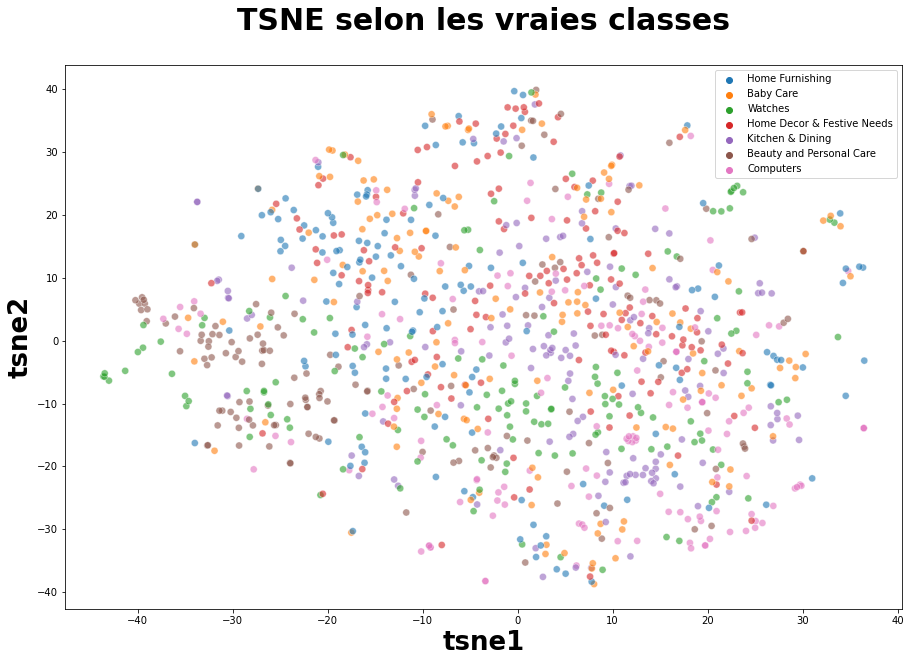

In [27]:
#Affichage des clusters avec les catégories réelles
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()


In [28]:
#KMEANS
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


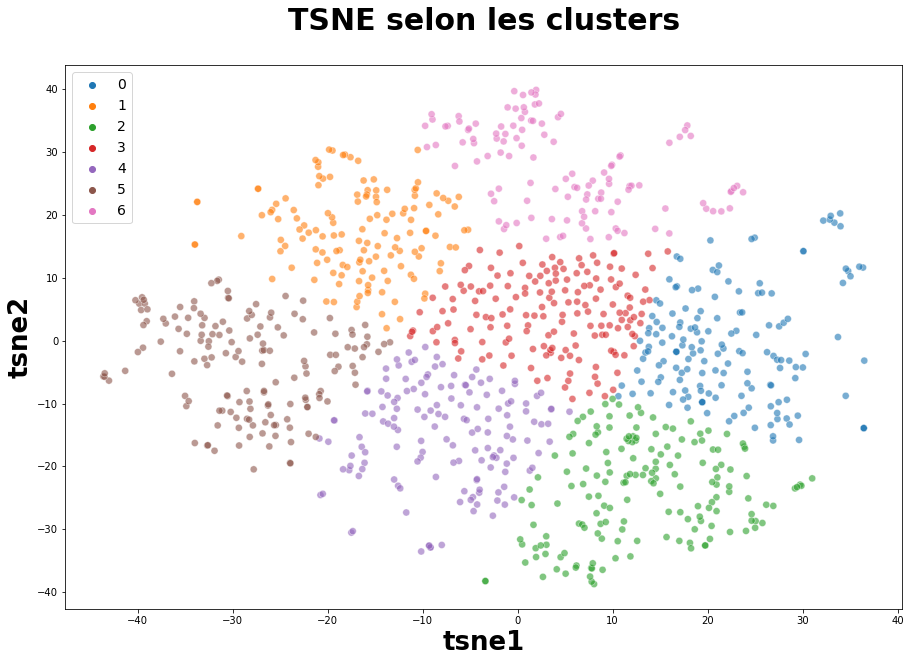

ARI :  0.059426481989191295


In [29]:
# Affichage des clusters selon notre modélisation
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_image["categorie_article"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Approche CNN (VGG16)

VGG16 est un réseau de neurone convolutif créée par K. Simonyan et A. Zisserman de l'université d'Oxford dans le papier “Very Deep Convolutional Networks for Large-Scale Image Recognition” Ce modèle à 92.7% d'accuracy sur le jeu de donnée Imagenet qui contient 14 million d'image labélisées en 1000 classes. Ce modèle est intéressant pour notre cas d'usage car nous avons des images similaires comme les montres.

In [30]:
#Fonction qui permet 
def img_to_array(img, data_format='channels_last', dtype='float32'):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format,
            either "channels_first" or "channels_last".
        dtype: Dtype to use for the returned array.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: %s' % data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=dtype)
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: %s' % (x.shape,))
    return x

#img = img_to_array(Image.open("2.jpg"))
#print(img)

In [31]:
# test sur une image
image = load_img('5.jpg', target_size=(224, 224))
image = img_to_array(image)
image.shape

(224, 224, 3)

In [32]:
# Test de VGG16 sur une image

model = VGG16(include_top=True, input_shape=(224, 224, 3), weights='imagenet')
image = load_img('5.jpg', target_size=(224, 224))
image = img_to_array(image)
print(image.shape)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print(image.shape)
image = preprocess_input(image)
prediction = model.predict(image)
label = decode_predictions(prediction)
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

2022-07-02 21:21:44.474303: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(224, 224, 3)
(1, 224, 224, 3)
digital_watch (50.11%)


In [33]:

# load an image from file
image = load_img('1.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# get extracted features
features = model.predict(image)
print(features.shape)
# save to file
dump(features, open('1.pkl', 'wb'))

(1, 4096)


In [34]:
features.shape
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
# identification of key points and associated descriptors
CNN_keypoints = []

temps1=time.time()

for image_num in range(len(df_image.values)) :
    if image_num%100 == 0 : print(image_num,"traités")
    #image = cv2.imread(df_image.loc[image_num,"image_propre"],0)
    image = load_img(df_image.loc[image_num,"image_propre"], target_size=(224, 224))
    #print(df_image.loc[image_num,"image_propre"])
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image=preprocess_input(image)
    features = model.predict(image)
    CNN_keypoints.append(features)

0 traités
100 traités
200 traités
300 traités
400 traités
500 traités
600 traités


/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700 traités
800 traités
900 traités
1000 traités


In [36]:
CNN_keypoints_by_img = np.asarray(CNN_keypoints)
CNN_keypoints_all    = np.concatenate(CNN_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", CNN_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (1050, 4096)
temps de traitement SIFT descriptor :           164.67 secondes


In [37]:
#features_images=CNN_keypoints_all
#CNN_keypoints_all.shape

In [38]:
#ACP
im_features = CNN_keypoints_all

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 813)


In [39]:
#TSNE
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_image["categorie_article"]
print(df_tsne.shape)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


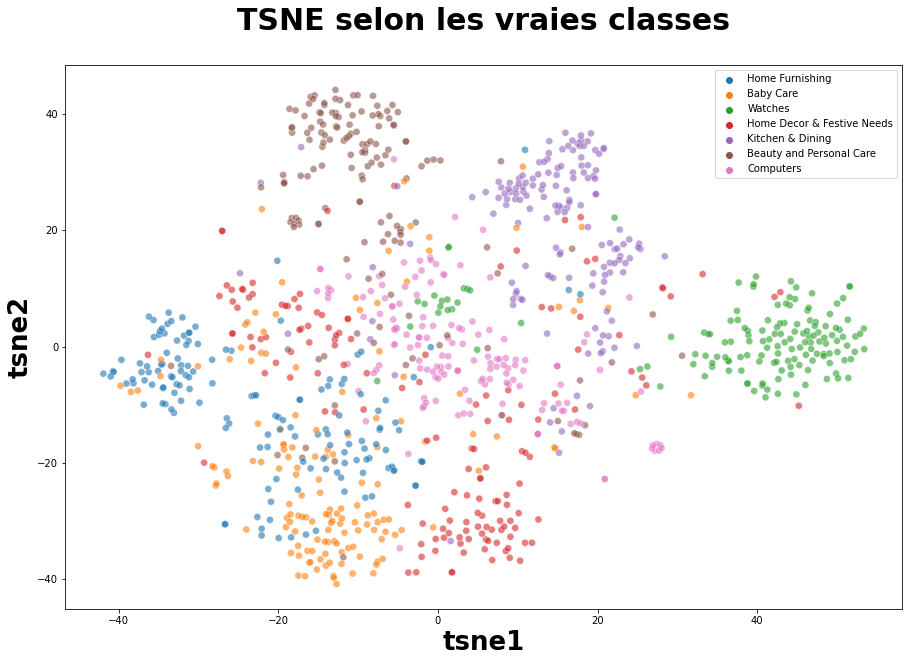

In [40]:
#Visualisation
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()


In [41]:
#KMEANS
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


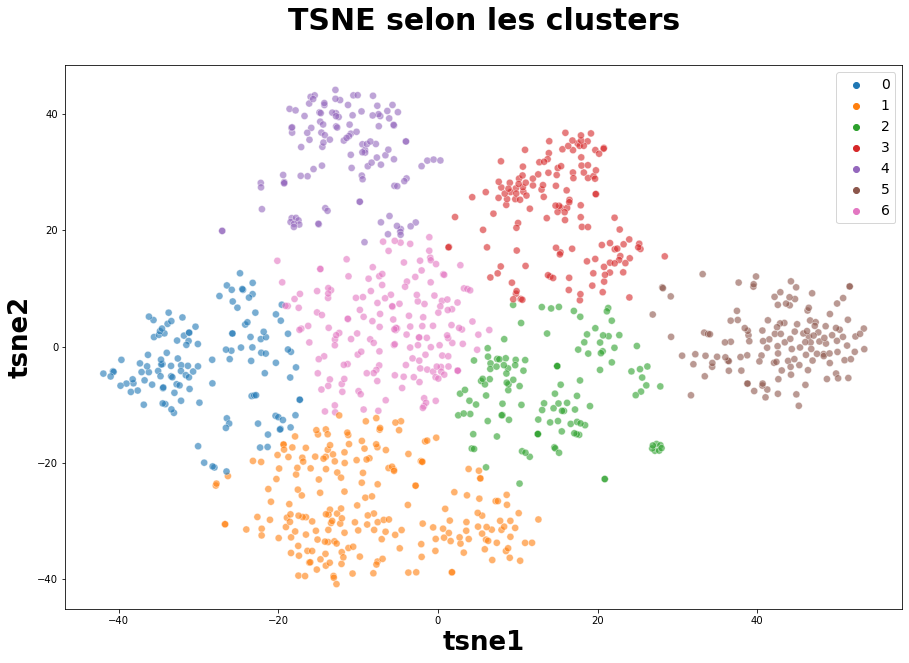

ARI :  0.4023258609587413


In [42]:
#Visualisation
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_image["categorie_article"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
features_images=df_tsne[["tsne1","tsne2"]]

In [43]:
#Tableau de contingence
pd.crosstab(df_tsne["class"], df_tsne["cluster"])

cluster                      0   1   2    3    4    5   6
class                                                    
Baby Care                   24  98   9    4    3    1  11
Beauty and Personal Care     2   5   9    4  110    2  18
Computers                    0   3  60    4    1    0  82
Home Decor & Festive Needs  23  58  24    6    4    7  28
Home Furnishing             80  54   0    3    0    0  13
Kitchen & Dining             2   1  19  120    3    0   5
Watches                      0   0   4    3    0  127  16

In [44]:
#Accuracy
for i in range(7):
    accuracy=(max(list(pd.crosstab(df_tsne["class"],df_tsne["cluster"]).values[i])))/(np.sum(list(pd.crosstab(df_tsne["class"],df_tsne["cluster"]).values[i])))
    print(accuracy)

0.6533333333333333
0.7333333333333333
0.5466666666666666
0.38666666666666666
0.5333333333333333
0.8
0.8466666666666667


# Partie Texte

Dans cette partie, nous étudierons la faisabilité d'un moteur de classiffication en utilisant uniquement les descriptions des articles de notre échantillon.

In [45]:
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

### Pré-processing

Dans cette partie nous préparons les données textuelles.

In [46]:
test=df["description"][9]+df["product_name"][9]
test


'TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men - Buy TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men  CAU1116.BA0858 Online at Rs.107750 in India Only at Flipkart.com. Swiss-made, Quartz movement, Scratch resistant, Sapphire crystal glass, Water resistant to 200 metres, Feature Chronograph - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men'

In [47]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# En minuscule
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words]
    return lw

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def sans_chiffre(toto):
    number=["0","1","2","3","4","5","6","7","8","9"]
    for i in range(10):
        toto=[ x for x in toto if number[i] not in x ]
    return(toto)

def mots_inutiles(toto):
    number=['flipkart.com','price','free','.....',]
    for i in range(4):
        toto=[ x for x in toto if number[i] not in x ]
    return(toto)



test=df["description"][9]+df["product_name"][9]
test2=mots_inutiles(sans_chiffre(lemma_fct(lower_start_fct(stop_word_filter_fct(tokenizer_fct(test))))))
test2

['tag',
 'heuer',
 'formula',
 'analog',
 'watch',
 'for',
 'boy',
 'men',
 'buy',
 'tag',
 'heuer',
 'formula',
 'analog',
 'watch',
 'for',
 'boy',
 'men',
 'online',
 'india',
 'only',
 'swiss',
 'made',
 'quartz',
 'movement',
 'scratch',
 'resistant',
 'sapphire',
 'crystal',
 'glass',
 'water',
 'resistant',
 'metre',
 'feature',
 'chronograph',
 'great',
 'discount',
 'only',
 'genuine',
 'product',
 'day',
 'replacement',
 'guarantee',
 'shipping',
 'cash',
 'delivery',
 'tag',
 'heuer',
 'formula',
 'analog',
 'watch',
 'for',
 'boy',
 'men']

In [48]:
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    sc=sans_chiffre(lem_w)
    smi=mots_inutiles(sc)
    transf_desc_text = ' '.join(smi)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['sentence_bow'] = df["description"].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] =df["description"].apply(lambda x : transform_bow_lem_fct(x))+df["product_name"].apply(lambda x : transform_bow_lem_fct(x))
df['sentence_dl'] = df["description"].apply(lambda x : transform_dl_fct(x))+df["product_name"].apply(lambda x : transform_dl_fct(x))

In [49]:
l_cat = list(set(df["categorie_article"]))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]["categorie_article"])) for i in range(len(df))]

catégories :  ['Baby Care', 'Beauty and Personal Care', 'Watches', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining']


In [50]:
y_cat_num = [(l_cat.index(df.iloc[i]["categorie_article"])) for i in range(len(df))]

In [51]:

df['length_bow'] = df['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['length_bow'].max())
df['length_dl'] = df['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())


max length bow :  379
max length dl :  636


In [52]:
len(df.description[3].split())

145

In [53]:
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [54]:


# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(25,13))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des articles par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des articles par clusters')
    
    plt.show()
    print("ARI : ", ARI)
    
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

### Approche bag of word comptage mot

L'approche comptage de mots consiste juste à compter les mots  des textes dans un tableau avec les mots en colonnes et les textes en ligne.

In [55]:
pd.value_counts(test2)

tag            3
formula        3
analog         3
watch          3
for            3
boy            3
men            3
heuer          3
only           2
resistant      2
india          1
feature        1
cash           1
shipping       1
guarantee      1
replacement    1
day            1
product        1
genuine        1
discount       1
great          1
chronograph    1
metre          1
online         1
water          1
glass          1
crystal        1
sapphire       1
buy            1
scratch        1
movement       1
quartz         1
made           1
swiss          1
delivery       1
dtype: int64

In [56]:
cv_transform.shape

(1050, 4954)

In [57]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()

CountVectorizer : 
-----------------
ARI :  0.4781 time :  5.0



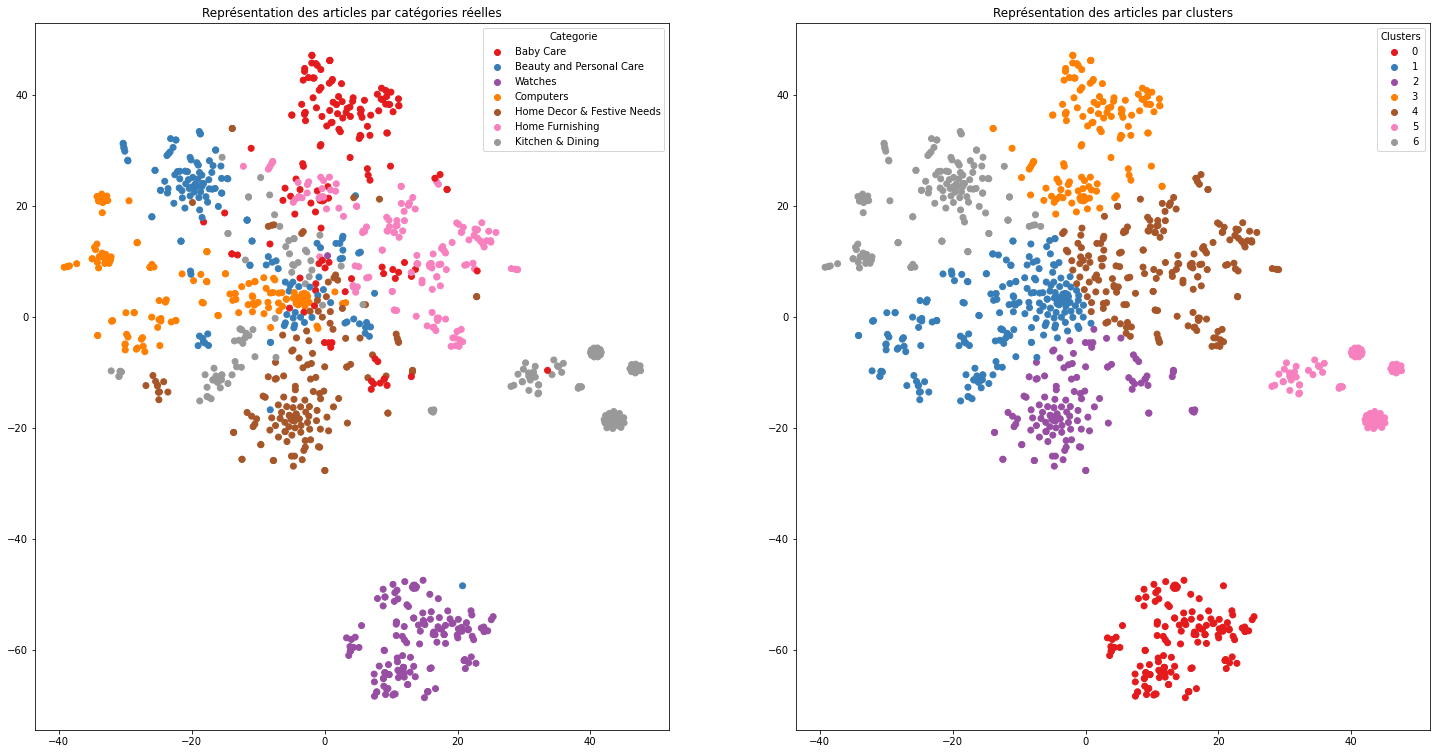

ARI :  0.4781


In [58]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Approche bag of word Tf-idf

L'approche Tf-idf de mots consiste juste à compter les mots  des textes dans un tableau avec les mots en colonnes et les textes en ligne. Sauf que cette fois nous avantageons les mots discriminants grâce à une pondération qui réduit l'importance des mots présents partout.

In [91]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

Tf-idf : 
--------
ARI :  0.5225 time :  5.0


In [92]:
features_texte=X_tsne

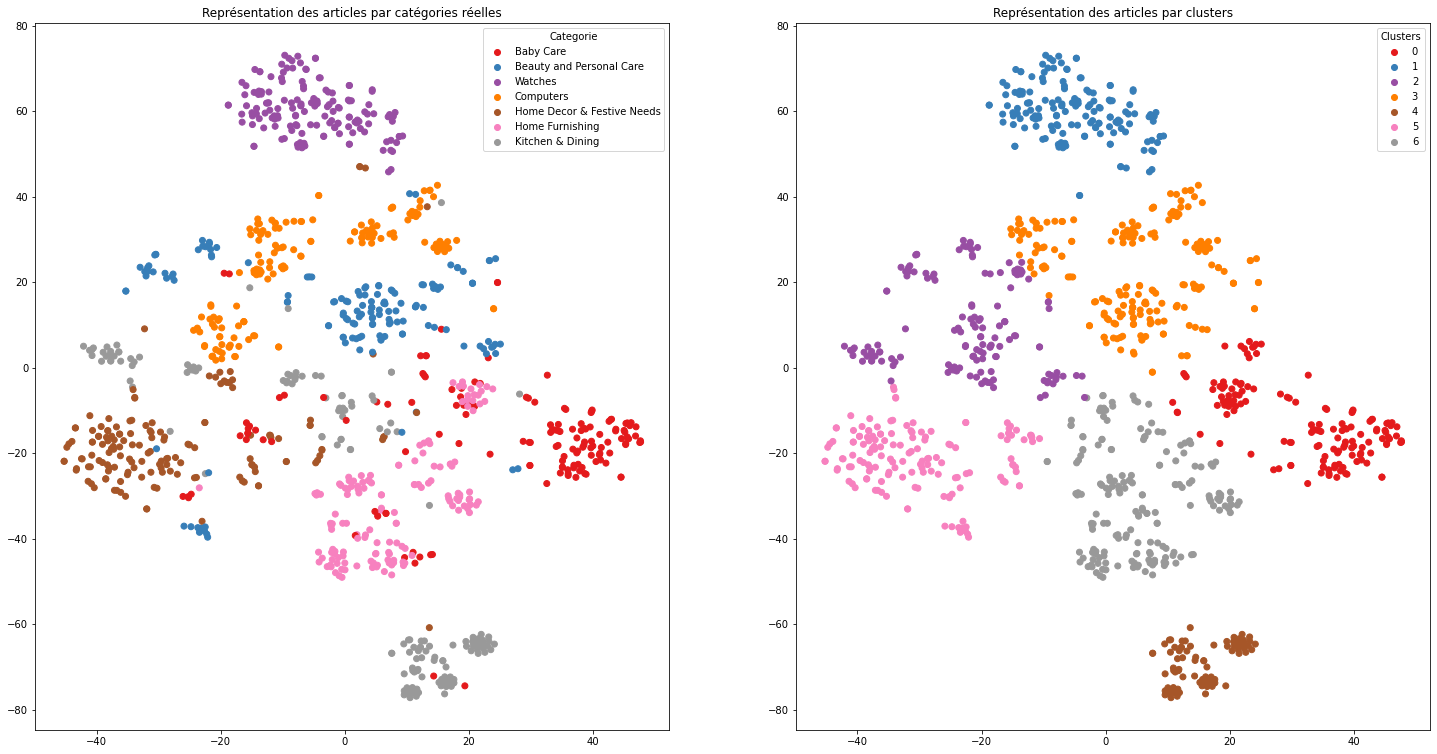

ARI :  0.5225


In [61]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [62]:
#calcul accuracy
np.unique(y_cat_num)
np.unique(cls.labels_)
pd.crosstab(y_cat_num,labels)
for i in range(7):
    accuracy=(max(list(pd.crosstab(y_cat_num,labels).values[i])))/(np.sum(list(pd.crosstab(y_cat_num,labels).values[i])))
    print(accuracy)

0.72
0.6333333333333333
1.0
0.6266666666666667
0.7933333333333333
0.8666666666666667
0.49333333333333335


### Approche Word2Vec 

Word2vec est une méthode pour créer des word embeddings. Word2vec génère des embeddings qui sont indépendants de leur contexte? Chaque mot est représenté par un vecteur unique.

In [63]:
#Initialisation Word2vec
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 379 # paramètre à adapter en fonction de la longueur de nos phrases
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [64]:
# Création et entraînement du modèle Word2Vec

w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Taille du vocabulaires : %i" % len(w2v_words))

Taille du vocabulaires : 4995


In [65]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4996


In [66]:
# Création de la matrice d'embedding
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Word embedding rate :  1.0
Embedding matrix: (4996, 300)


In [67]:
# Création du modèle
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 379)]             0         
                                                                 
 embedding (Embedding)       (None, 379, 300)          1498800   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,498,800
Trainable params: 1,498,800
Non-trainable params: 0
_________________________________________________________________


In [68]:
#Prédictions des clusters
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [69]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.4051 time :  4.0


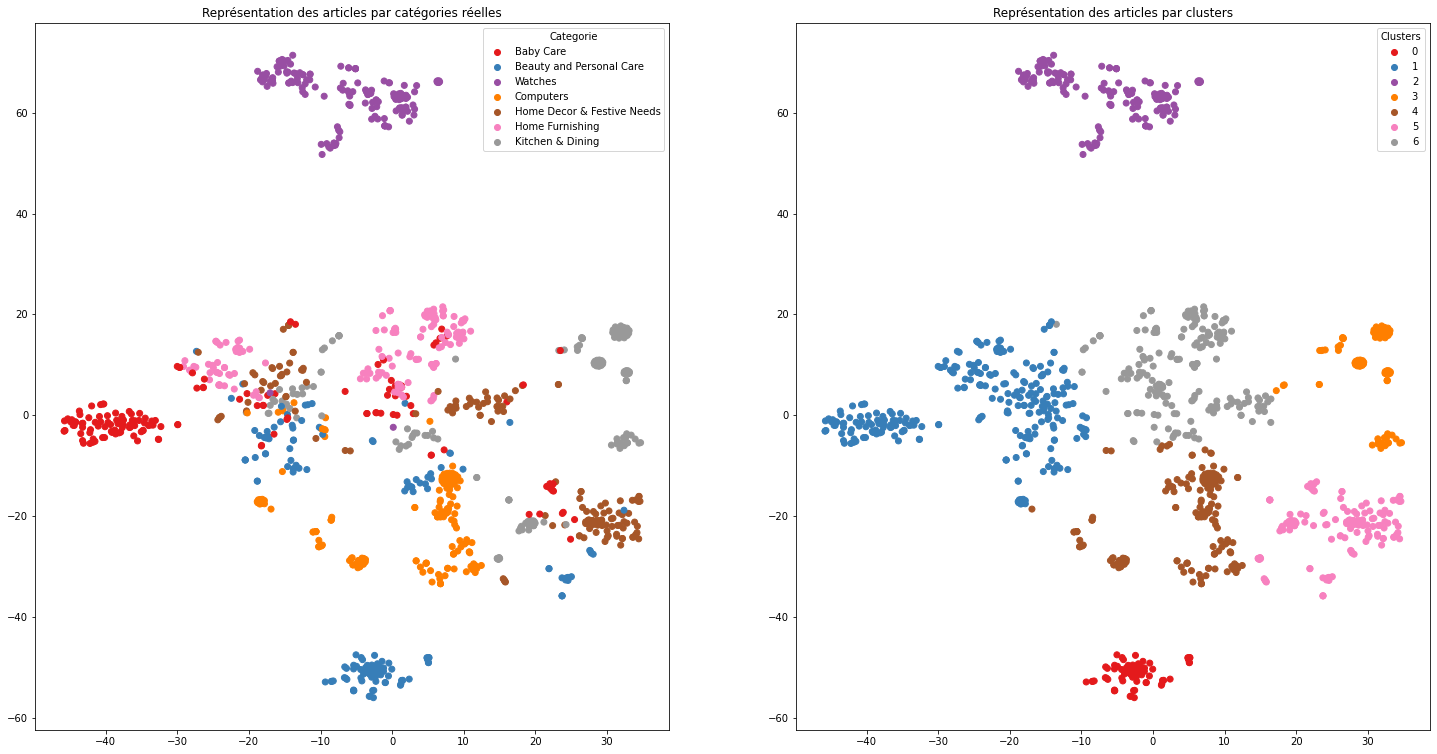

ARI :  0.4051


In [70]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Approche BERT

BERT ou encore Bidirectional Encoder Representations from Transformers est un modèle de représentation de textes écrit en langage naturel. La représentation faite par BERT à la particularité d’être contextuelle. C’est-à-dire qu’un mot n’est pas représenté de façon statique comme dans un embedding classique mais en fonction du sens du mot dans le contexte du texte. Par exemple, le mot « baguette » aura des représentations différentes dans « la baguette du magicien » et « la baguette du boulanger ». BERT est pré-entraîné sur un grand jeu de données constitué de textes des pages Wikipédia en anglais (2 500 millions de mots) ainsi qu’un ensemble de livres (800 millions de mots).

In [71]:
os.environ["TF_KERAS"]='1'

In [72]:
#Fonction BERT
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [73]:
# Initialisation Bert
max_length = 64
batch_size = 105
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [74]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  57.0


In [75]:
#Calcul ARI
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3591 time :  4.0


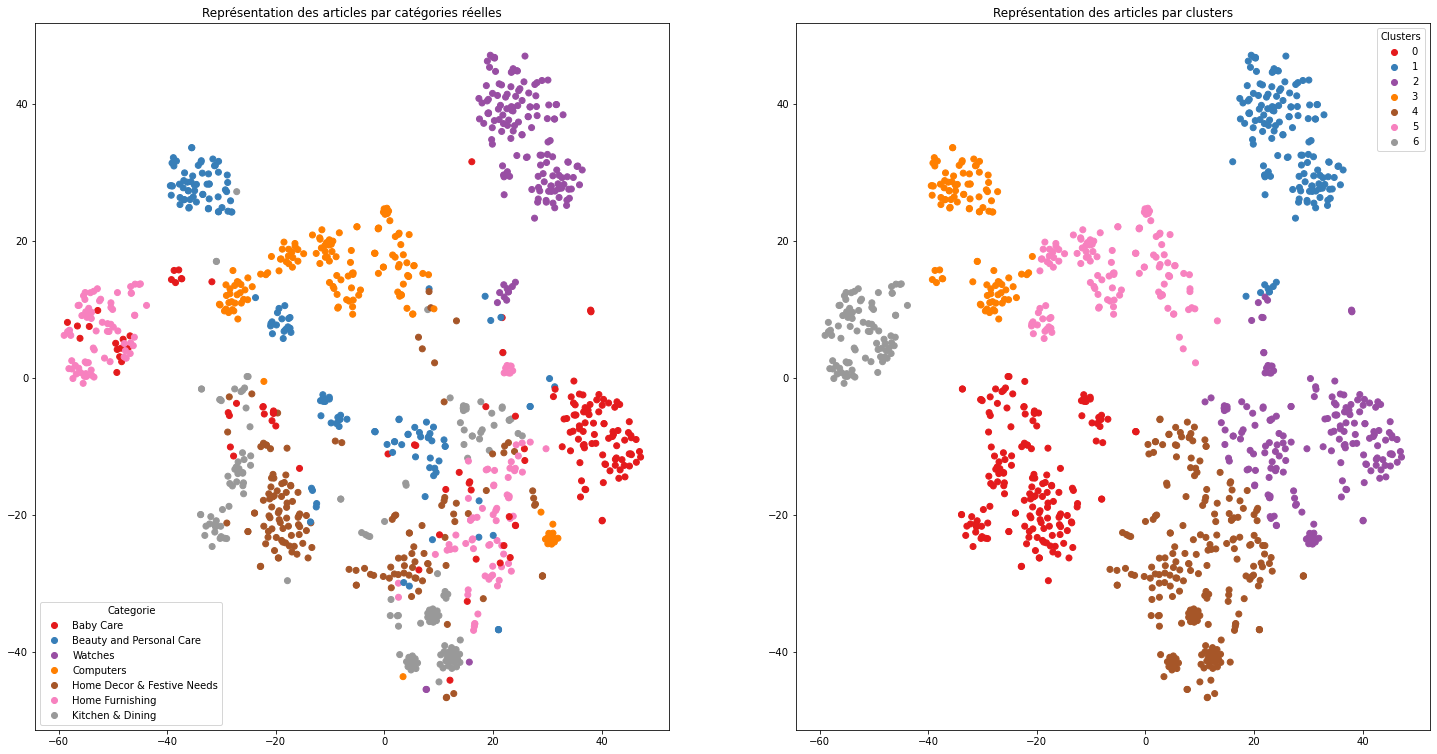

ARI :  0.3591


In [76]:
#Visualisation
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Approche USE

The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. 

https://tfhub.dev/google/universal-sentence-encoder/4

In [77]:
os.environ["TF_KERAS"]='1'

In [78]:
#pip install CpmTokenizer

In [79]:
#Information environnement
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
False


In [80]:
# Chargement de USE
try :
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
except :
    print("pas de GPU")

pas de GPU


In [81]:
# Fonction de calcul des features
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [82]:
# Utilisation de USE
batch_size = 10
sentences = df['sentence_dl'].to_list()
try :
    features_USE = feature_USE_fct(sentences, batch_size)
except :
    print("pas de GPU")

pas de GPU


In [83]:
#Visualisation
try :
    ARI, X_tsne, labels = ARI_fct(features_USE)
    TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
except :
     print("pas de GPU")

pas de GPU


# Conclusion

Un moteur de classification semble être faisable en supervisé.

Remarque : Les catégories que nous avons utilisés sont des fois très général comme la catégorie 'computer', cela peut autant être un chargeur qu'une clé usb à hélice. Peut-être revoir les catégories.

## Bonus test TSNE images CNN + TSNE TF_IDF

On va essayer de mixer les approches images et textes dans un même modèle.

In [94]:
#Modele ensembliste

features_images=features_images.to_numpy() #TSNE image VGG16
features_texte=features_texte #TSNE texte bag of word tfidt
data=np.append(features_images ,features_texte, axis=1)

#TSNE CALCUL
tsne = manifold.TSNE(n_components=2, perplexity=77, 
                     n_iter=1000, init='random', random_state=10)
X_tsne = tsne.fit_transform(data)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_image["categorie_article"]
print(df_tsne.shape)

2022-07-02 21:29:38,310 [38369] WARNING  py.warnings:109: [JupyterRequire] /opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



(1050, 3)


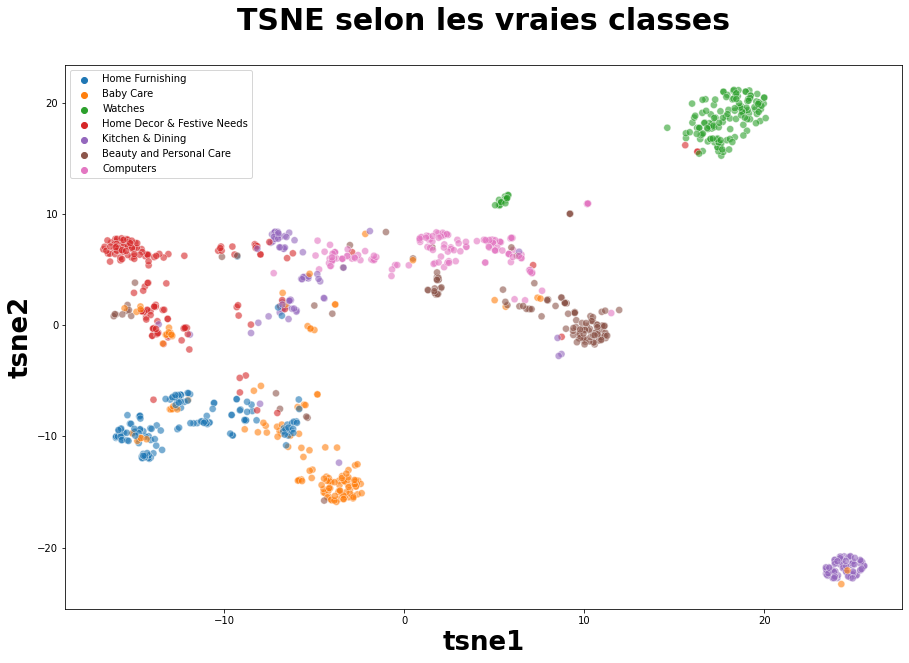

In [95]:
#visualisation
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

In [96]:
#Kmeans
cls = cluster.KMeans(n_clusters=7, random_state=10)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


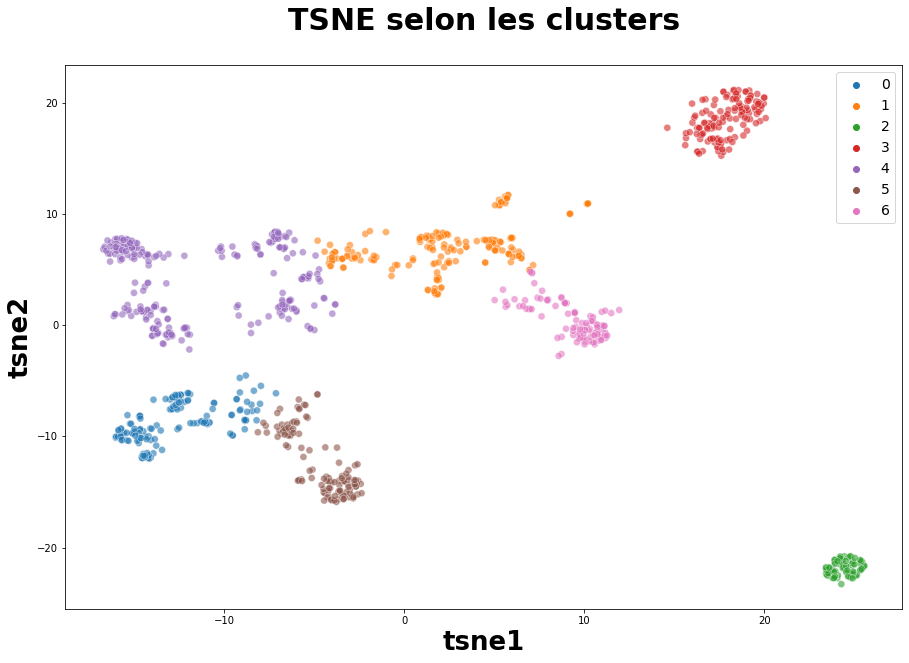

ARI :  0.5594854063284185


In [97]:
#Visualisation 
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_image["categorie_article"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

En conclusion une approche ensembliste en prenant en compte les features texte et image peut fonctionner en non supervisée.